In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import ConfusionMatrix,F1Score
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Pre-Processing

In [ ]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
valid_set['Text'] = valid_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
valid_set['Text'] = valid_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save Pre-Processed Data

In [ ]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Load Pre-Processed Data

In [2]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

Tokenize Text and create W2V Model

In [3]:
#Tokenize text so word2vec can utilize it
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

#Create Word2Vec models
model = Word2Vec(sentences=train_set['Tokenized_Text'], vector_size=300,window=5,min_count=2,negative = 10)

#Train the model
model.train(train_set['Tokenized_Text'], total_examples= len(train_set['Text']), epochs=30)

#Save the model
model.save("./Data/word2vec_new.model")

Load self-trained Word2Vec Model

In [3]:
word2vec_model = Word2Vec.load('./Data/word2vec_new.model')

Tokenize Texts

In [4]:
#Tokenize all texts
valid_set['Tokenized_Text'] = valid_set['Text'].apply(lambda x: word_tokenize(x))
test_set['Tokenized_Text'] = test_set['Text'].apply(lambda x: word_tokenize(x))
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

In [5]:
print(word2vec_model.wv.most_similar('μητσοτακης'))

[('Μητσοτακης', 0.5311290621757507), ('συρρικνωσει', 0.3812375068664551), ('φορων', 0.3534460961818695), ('μεγαλοεπιχειρηματιος', 0.3458263874053955), ('προχωρησει', 0.3422377109527588), ('μητσοτακη', 0.339499831199646), ('λουτσεσκος', 0.33809322118759155), ('πειστικος', 0.321236252784729), ('περικοπω', 0.3175898790359497), ('διαλογο', 0.31199774146080017)]


Encode Labels

In [57]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment']) #Transform the labels
X_valid_labels = encoder.fit_transform(valid_set['Sentiment']) #For both training and validation

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


Convert Tweets to Vectors

In [7]:
def ConvertTextToVector(text): 
    word_emdeddings = []
    for sentence in text: #iterate the description column
        vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] #for each word in each row of the description column
        if vectors: #check if the word exists in the vocabulary and get the vectors for each word
            mean = np.mean(vectors, axis=0) #calculate the mean of the vectors
        else:
            np.zeros(word2vec_model.vector_size) #add an array of 200 with elements of 0
        word_emdeddings.append(mean) #append the vector the the list
    return np.array(word_emdeddings)

wordvec_train_arrays = ConvertTextToVector(train_set['Text']) #Convert all tweets to vectors
wordvec_valid_arrays = ConvertTextToVector(valid_set['Text'])#By finding the mean of all the vectors
wordvec_test_arrays = ConvertTextToVector(test_set['Text'])#Of all the words in each tweet



Check Shape

In [8]:
wordvec_train_arrays.shape

(36630, 300)

Create Tensorflow tensors

In [29]:
batch_size = 16
#Train set
X_train_tensor = torch.tensor(wordvec_train_arrays,dtype=torch.float) #Create a tensor from the tweets
Labels_train_tensor = torch.tensor(X_train_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #Create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the train set


#Val set
X_val_tensor = torch.tensor(wordvec_valid_arrays,dtype=torch.float)#Create a tensor from the tweets
Labels_val_tensor = torch.tensor(X_valid_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #Create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set


X_test_tensor = torch.tensor(wordvec_test_arrays,dtype=torch.float)#Create a tensor from the tweets
Dataset = TensorDataset(X_test_tensor) #Create a dataset
Test_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the test set

Set Gpu Or Cpu

In [10]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


FeedForward Neural Network

In [11]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate= 0.5): #initialize feedforward network
        super(FeedForwardNeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(300, 128) #First linear layer,input is 300 which is the dimension of our tweets-vectors
        self.dropout1 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear4 = nn.Linear(32, 3) #3 outputs since we have 3 classes
        
    def forward(self, x):
        h1 = F.relu(self.linear1(x))
        h2 = F.relu(self.linear2(h1))
        h3 = F.relu(self.linear3(h2))
        out = self.linear4(h3)
        return out

Train Function

In [12]:
def Train(dataLoader,model,loss_fn,optimizer):
    losses = []
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    counter = 0
    for batch, (X,y) in enumerate(dataLoader): #iterate all the dataset

        X = X.to(device) #Load variables to GPU
        y = y.to(device) #Load variables to GPU
        
        pred = model(X) #predict the label

        loss = loss_fn(pred,y) #find the loss between the prediction and the true label
        losses.append(loss.item())

        #BackPropagation
        optimizer.zero_grad() #reset all the gradients

        loss.backward()
        
        optimizer.step() #perform a step

        f1 += f1_score(pred.argmax(1),y) #calculate the f1 score
        counter+=1
    f1 /= counter #find the average f1 score    
    return f1, sum(losses)/len(losses)

Validation Function

In [13]:
def Validation(dataloader,model,loss_fn):
    size = len(dataloader.dataset) #get the size of the dataset
    test_loss,correct,f1 = 0,0,0 #declare variables
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device) 
    counter = 0

    with torch.no_grad(): #disable gradient caclulation since we are testing not training
        for X,y in dataloader:

            X = X.to(device) #Load to GPU
            y = y.to(device) #Load to GPU

            pred = model(X) #predict the label

            test_loss += loss_fn(pred,y).item() #find the loss_fn
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() #find the accuracy
            f1 += f1_score(pred.argmax(1),y) #find the f1 score
            counter +=1

    test_loss /= counter #compute the average loss
    correct /= size #average accuracy
    f1 /= counter #average f1 score
    confmat = ConfusionMatrix('multiclass',num_classes=3).to(device)
    confusion_matrix = confmat(pred,y) #find the confusion matrix
    
    return f1,test_loss,correct,confusion_matrix

Learning Curve Function

In [14]:
def plot_loss_learning_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs,train_losses, label='Training Loss')
    plt.plot(epochs,val_losses, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

def plot_f1_learning_curve(train_f1, val_f1):
    epochs = range(1, len(train_f1) + 1)

    plt.plot(epochs,train_f1, label='Training F1')
    plt.plot(epochs,val_f1, label='Validation F1')

    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

$
\begin{array}{|c|c|c|c|}
\hline
\text{Optimizer} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{SGD} & \text{33.3\%} & \text{0.170761} & \text{1m26.6s}\\
\hline
\text{Adadelta} & \text{33.3\%} & \text{0.170319} & \text{1m27.9s}\\
\hline
\text{Adagrad} & \text{33.8\%} & \text{0.311493} & \text{1m34.1s}\\
\hline
\text{Adagrad} & \text{34.8\%} & \text{0.327325} & \text{2m35.4s 50 EPOCHS}\\
\hline
\text{Adagrad} & \text{36.8\%} & \text{0.368264} & \text{2m36.8s 50 EPOCHS learningRate = 1e-3}\\
\hline
\text{Adam} & \text{37.1\%} & \text{0.371074} & \text{1m26.7s}\\
\hline
\text{Adam} & \text{37.3\%} & \text{0.368761} & \text{2m36.8s 50 EPOCHS learningRate = 1e-5}\\
\hline
\text{AdamW} & \text{37.0\%} & \text{0.368899} & \text{1m25.0s}\\
\hline
\text{Adamax} & \text{37.0\%} & \text{0.368293} & \text{1m42.4s}\\
\hline
\end{array}
$

So now we test with 50 epochs,will increase to 60 when early stopping is included

$
\begin{array}{|c|c|c|}
\hline
\text{Activator} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{ReLu} & \text{37.3\%} & \text{0.368761}\\
\hline
\text{ELU} & \text{36.6\%} & \text{0.364278}\\
\hline
\text{HardShrink} & \text{33.3\%} & \text{0.171157}\\
\hline
\text{HardSigmoid} & \text{34.7\%} & \text{0.325575}\\
\hline
\text{HardTanh} & \text{36.6\%} & \text{0.363918}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Learning Rate} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{1e-4} & \text{37.1\%} & \text{0.371074}\\
\hline
\text{1e-5} & \text{37.3\%} & \text{0.368761}\\
\hline
\text{1e-6} & \text{35.2\%} & \text{0.272236}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|c|}
\hline
\text{Patience} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{3} & \text{36.0\%} & \text{0.356683} & \text{45.8s}\\
\hline
\text{5} & \text{35.8\%} & \text{0.352698} & \text{44.2s}\\
\hline
\text{10} & \text{36.6\%} & \text{0.364468} & \text{1m4.9s}\\
\hline
\text{15} & \text{36.4\%} & \text{0.362527} & \text{1m48.7s}\\
\hline
\text{None-20} & \text{36.6\%} & \text{0.365343} & \text{3m0.5s}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Scheduler} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{LinearLR} & \text{36.6\%} & \text{0.361416}\\
\hline
\text{PolynomialLR} & \text{35.2\%} & \text{0.324691}\\
\hline
\text{ExponentialLR} & \text{36.4\%} & \text{0.348560}\\
\hline
\text{CosineAnnealingLR} & \text{36.6\%} & \text{0.366208}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Dropout Rate} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{0} & \text{36.6\%} & \text{0.366208}\\
\hline
\text{0.2} & \text{36.8\%} & \text{0.368184}\\
\hline
\text{0.3} & \text{36.8\%} & \text{0.362087}\\
\hline
\text{0.5} & \text{36.4\%} & \text{0.362567}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|c|}
\hline
\text{Batch Size} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{8} & \text{36.8\%} & \text{0.369066} & \text{16m5.1s DROPOUT=0.5}\\
\hline
\text{8} & \text{36.9\%} & \text{0.371997} & \text{16m5.1s}\\
\hline
\text{16} & \text{37.2\%} & \text{0.370520} & \text{7m33.0s}\\
\hline
\text{16} & \text{37.2\%} & \text{0.368731} & \text{5m51.3s}\\
\hline
\text{32} & \text{37.1\%} & \text{0.368721} & \text{5m17.9s}\\
\hline
\text{64} & \text{36.6\%} & \text{0.362117} & \text{1m35.5s}\\
\hline
\text{128} & \text{36.9\%} & \text{0.366861} & \text{47.2s}\\
\hline
\end{array}
$

Optimizing

Epoch 1
-------------------------------
tensor(0.3102)
Epoch 2
-------------------------------
tensor(0.3365)
Epoch 3
-------------------------------
tensor(0.3076)
Epoch 4
-------------------------------
tensor(0.3458)
Epoch 5
-------------------------------
tensor(0.3396)
Epoch 6
-------------------------------
tensor(0.3348)
Epoch 7
-------------------------------
tensor(0.3325)
Epoch 8
-------------------------------
tensor(0.3567)
Epoch 9
-------------------------------
tensor(0.3478)
Epoch 10
-------------------------------
tensor(0.3412)
Epoch 11
-------------------------------
tensor(0.3509)
Epoch 12
-------------------------------
tensor(0.3605)
Epoch 13
-------------------------------
tensor(0.3564)
Epoch 14
-------------------------------
tensor(0.3537)
Epoch 15
-------------------------------
tensor(0.3520)
Epoch 16
-------------------------------
tensor(0.3424)
Epoch 17
-------------------------------
tensor(0.3550)
Epoch 18
-------------------------------
tensor(0.3425)
E

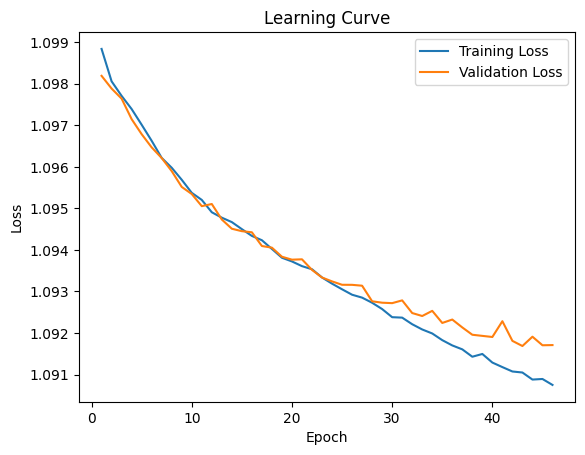

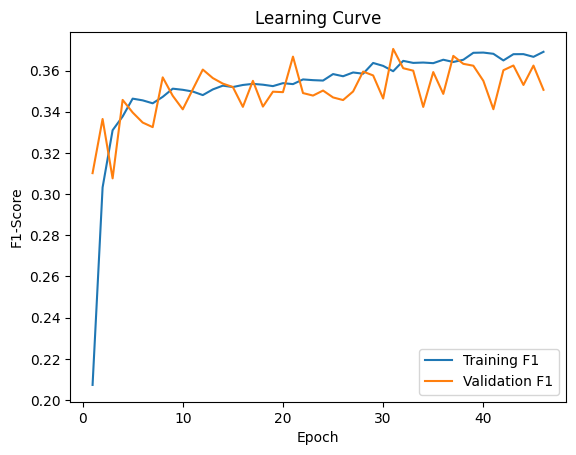

In [30]:
loss_fn = nn.CrossEntropyLoss()
best_f1 = 0 #initialize variables
best_loss = 0
best_accuracy = 0
learning_rate = 1e-5
patience = 0
epochs_count = 60
patience_tol = 15
f1_train_scores = []
f1_val_scores = []
train_losses = []
val_losses = []

model = FeedForwardNeuralNetwork(dropout_rate = 0.2).to(device) #Create a feedforward network instance

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for t in range(epochs_count): #iterate over the number of epochs
    print(f"Epoch {t+1}\n-------------------------------")
    torch.cuda.synchronize()

    f1_train,train_loss = Train(Train_set,model,loss_fn,optimizer) #train the convo network
    f1_train_scores.append(f1_train.cpu())
    train_losses.append(train_loss)
    f1_val,val_loss,accuracy,confusionMatrix = Validation(Validation_set,model,loss_fn) #find the current f1 score

    print(f1_val.cpu())
    f1_val_scores.append(f1_val.cpu())
    val_losses.append(val_loss)


    if f1_val > best_f1: #if it the best one yet
        best_f1 = f1_val #set it as the best one
        best_loss = val_loss
        best_confmat = confusionMatrix
        best_accuracy = accuracy
        new_best_model = model #this is the best model yet
        patience = 0
    else:
        patience+=1 #else increment patience
    if patience == patience_tol: #if we have iterated over a number of epochs and still the model we found is the best one
        break #break from the iteration

print(f"Test Error: \n Accuracy: {(100*best_accuracy):>0.1f}%, Avg loss: {best_loss:>8f},Avg F1-Score: {best_f1:>8f}\n") #print statistics
print(f"Confusion Matrix \n: {best_confmat}\n") #print confusion matrix
plot_loss_learning_curve(train_losses=train_losses,val_losses=val_losses)
plot_f1_learning_curve(train_f1=f1_train_scores,val_f1=f1_val_scores)

RELU is the best.

We can see that optimizers performace differs with learning rates,Adagrad was particularly interesting since it seems to generalize better compared to the other algorithms.

5 Epochs not enough,incrase number to 10,20,30

As we can see with slower learning rate the is managing to generalize better,but also shows more epochs are needed,so epochs go to 60 ,and patience is included

Predict Test Labels

In [63]:
Predictions = []

with torch.no_grad(): #disable gradient caclulation since we are testing not training
    for X in Test_set:
        X = X[0].to(device) #Load to GPU

        pred = new_best_model(X) #predict the label
        Predictions.append(pred.argmax(1).cpu().numpy())

Predictions = np.concatenate(Predictions)

In [64]:
#Create a dataframe based on a dictionary of the IDs and the predictions
y_test = pd.DataFrame(data={'Id': test_set['New_ID'], 'Predicted': Predictions})

#Convert the predicted labels [0,1,2] back to their corresponding labels [NEGATIVE,NEUTRAL,POSITIVE]
y_test['Predicted'] = y_test['Predicted'].apply(lambda x: labels.get(x,x))

#Save as csv
y_test.to_csv('sumbission.csv',index=False)

Number of epochs not enough for model to learn,increase to 10,then 20 and then 30